## LOG
#### [09/05/2020] 
- progress: completing training loop
- issues: TrainEvalCallback turns model into eval mode. It is not desired because torchvision.FasterRCNN has different behavior at eval mode
- issues: friction integrating metrics into the training loop
- issues: default datablock is not really suitable for torchvision.FasterRCNN

#### [10/05/2020]
- minor issue: train.json has duplicates dict in key 'images'

In [1]:
import os
import sys
path = os.path.join(os.getcwd(), '..')
sys.path.append(path)

import warnings 
warnings.filterwarnings("ignore")

from fastai2.vision.all import *

from src.data.dls import build_dataloaders
from src.data.dblock import build_dblock
#from src.metrics.map import calculate_image_precision
from src.model.FasterRCNN import get_faster_rcnn

%load_ext autoreload
%autoreload 2

In [2]:
from pdb import set_trace

In [3]:
data_path = '/userhome/34/h3509807/wheat-data'

#### -1. Sanity Check ```train.json```

In [4]:
from src.data.utils import decode_coco_json

In [5]:
json_path = Path(data_path) / 'train_mini.json'
img_ids, lbl_bbox, img2bbox = decode_coco_json(json_path)

In [6]:
len(img_ids), len(lbl_bbox), len(img2bbox)

(120, 120, 120)

#### 0. Testing TensorBBox

In [7]:
bbox = TensorBBox.create([10, 10, 100, 150], img_size = 256)
tfms = PointScaler()
enc = tfms(bbox)
enc

TensorBBox([[-0.9219, -0.9219, -0.2188,  0.1719]])

In [8]:
encs = torch.stack([enc[0] for i in range(5)])
encs

tensor([[-0.9219, -0.9219, -0.2188,  0.1719],
        [-0.9219, -0.9219, -0.2188,  0.1719],
        [-0.9219, -0.9219, -0.2188,  0.1719],
        [-0.9219, -0.9219, -0.2188,  0.1719],
        [-0.9219, -0.9219, -0.2188,  0.1719]])

In [9]:
TensorPoint((encs + 1) * tensor(256).float()/2, img_size = 256)

TensorPoint([[ 10.,  10., 100., 150.],
        [ 10.,  10., 100., 150.],
        [ 10.,  10., 100., 150.],
        [ 10.,  10., 100., 150.],
        [ 10.,  10., 100., 150.]])

#### 1a. Get DataBlock

In [21]:
dblk = build_dblock(Path(data_path), resize_sz = 256, 
                    norm = False, rand_seed = 144, test_mode = True)

In [22]:
ds = dblk.datasets(data_path + '/train')

In [27]:
xx = ds[0]
type(xx[0]), xx[0].shape, type(xx[1])

(fastai2.vision.core.PILImage, (1024, 1024), fastai2.vision.core.TensorBBox)

#### 1b. Get DataLoaders

In [21]:
dls = build_dataloaders(
    data_path, bs = 8, resize_sz = 256, 
    norm = False, rand_seed = 144, test_mode = True
    )

In [22]:
len(dls.train.items), len(dls.valid.items)

(96, 24)

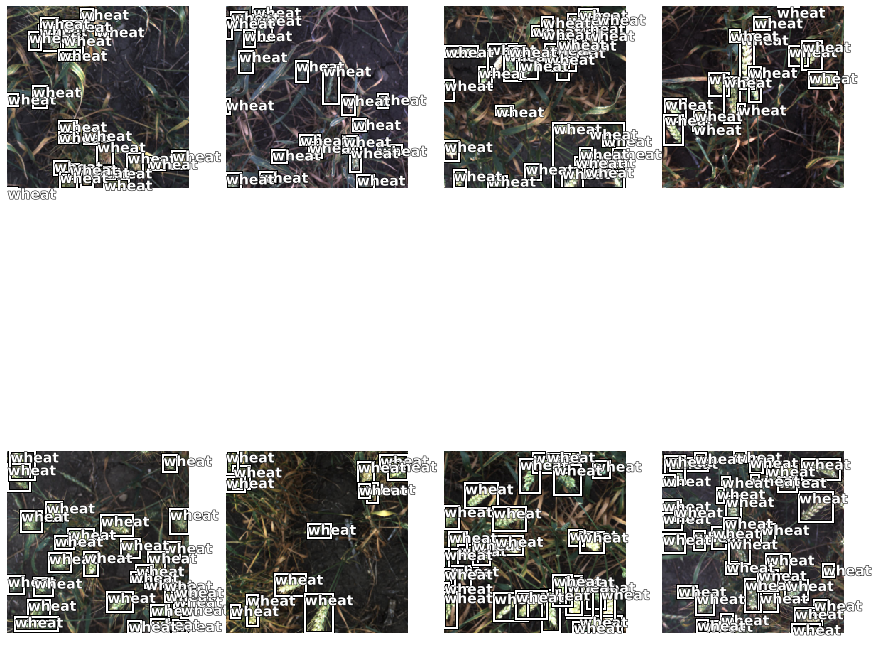

In [23]:
dls.show_batch(figsize = (15, 15))

In [17]:
# batch = (TensorImage, TensorBBox, TensorMultiCategory)
# TensorBBox: [BS, MAX BBOX NUMBER, 4]
# TensorMultiCategory: [BS, MAX BBOX NUMBER]
b = dls.one_batch()
type(b), type(b[0]), type(b[1]), type(b[2])

(tuple,
 fastai2.torch_core.TensorImage,
 fastai2.vision.core.TensorBBox,
 fastai2.torch_core.TensorMultiCategory)

In [18]:
b[0].shape, b[1].shape, b[2].shape

(torch.Size([8, 3, 1024, 1024]), torch.Size([8, 41, 4]), torch.Size([8, 41]))

In [19]:
b[0][0, 0, :3, :3]

tensor([[0.7333, 0.7961, 0.8039],
        [0.7255, 0.7922, 0.8235],
        [0.7216, 0.7725, 0.8235]], device='cuda:0')

In [20]:
b[1][0][0]

tensor([-1.0000, -0.9863, -0.7031, -0.7930], device='cuda:0')

#### 2. Setup Model

In [17]:
from torchvision.models.detection.generalized_rcnn import GeneralizedRCNN

device = torch.device('cuda')

In [18]:
model = get_faster_rcnn()
model = model.to(device)

#### 3. Setup Dummy Loss Function

In [19]:
import torch
import torch.nn as nn

In [20]:
class WeightedMultiLoss(nn.Module):
    def __init__(self):
        super().__init__()
    
    def forward(self, preds, tgts, **kwargs):
        loss = 0.
        for _, ind_loss in preds.items():
            loss += ind_loss
        return loss

In [21]:
multi_loss = WeightedMultiLoss()

In [22]:
isinstance(multi_loss, nn.Module)

True

#### 4. Freezing Selected Layers
- model.backbone
- model.rpn
- model.roi_heads

In [23]:
isinstance(model.roi_heads, nn.Module)

True

In [24]:
def _faster_rcnn_split(m):
    return L(m.backbone, nn.Sequential(m.rpn, m.roi_heads)).map(params)

#### 5. Setup Metrics

In [25]:
from functools import partial

In [26]:
thresholds = [i for i in map(lambda i: i/100, range(50, 80, 5))]
thresholds

[0.5, 0.55, 0.6, 0.65, 0.7, 0.75]

In [27]:
map_getter = partial(calculate_image_precision, thresholds = thresholds)

#### 6a. Setup Callback
- begin_batch: rearange target from tensor to list of dict
- after_pred: sort predicted bboxes by confidence score (descending order)

In [28]:
class FasterRCNNCallback(Callback):
    """ 
    essential changes for fastai2 Learner to interface with torchvision FasterRCNN 
    """
    def __init__(self, img_size):
        self.img_size = img_size
        
    def _decode_bboxs(self, enc_bboxs):
        sz = self.img_size
        return TensorPoint((enc_bboxs + 1)*tensor(256).float()/2, img_size = sz)
    
    def begin_batch(self):
        """ 
        re-arrange both self.learn.yb and self.learn.xb format
        self.learn.yb = [{'boxes': tensor(BS, 4), 'labels': tensor(BS)}, ...] 
        """
        # tupify, listify self.learn.xb
        self.learn.xb = ([x for x in self.learn.xb[0]], ) 
        
        # tupify, listify, dictionarize yb
        bboxs_b, cats_b = self.learn.yb
        
        yb = []
        for bboxs, cats in zip(bboxs_b, cats_b):
            idxs = torch.where(cats != 0)
            tmp_dict = {'boxes': self._decode_bboxs(bboxs[idxs]), 
                        'labels': cats[idxs]}
            yb.append(tmp_dict)
        
        self.learn.yb = (yb,)
        return None

#### 6b. Change TrainEvalCallback Behavior
no need activate eval mode in validation set

In [29]:
@patch
def begin_validate(self: TrainEvalCallback):
        "Set the model in validation mode"
        #self.model.eval()
        #print('begin validate, eval mode disabled!!!')
        self.learn.training=False

#### 7. Setup Learner

In [30]:
class WheatLearner(Learner):
    def one_batch(self, i, b):
        self.iter = i
        try:
            self._split(b);                                  self('begin_batch')
            
            # model(self.xb, self.yb) = loss
            self.pred = self.model(*self.xb, *self.yb);     self('after_pred')
                
            if len(self.yb) == 0: return
            
            self.loss = self.loss_func(self.pred, *self.yb);self('after_loss')
            if not self.training: return
            self.loss.backward();                            self('after_backward')
            self.opt.step();                                 self('after_step')
            self.opt.zero_grad()
        except CancelBatchException:                        self('after_cancel_batch')
        finally:                                            self('after_batch')

In [31]:
learn = WheatLearner(dls, model, 
                     loss_func = multi_loss, 
                     splitter = _faster_rcnn_split,
                     cbs = FasterRCNNCallback(img_size = 256))
                     #metrics = map_getter,

In [32]:
learn.freeze()

#### 8. Find Optimal Learning Rate

In [33]:
#learn.lr_find()

In [34]:
#learn.save('testing')

#### 9. Train + Unfreeze All Layers Except Backbone

In [35]:
learn.fit_one_cycle(15, 2e-4)

epoch,train_loss,valid_loss,time
0,4.437299,3.844306,01:18
1,3.458349,1.711766,00:55
2,2.635881,1.345940,00:55
3,2.148963,1.233750,00:55
4,1.843322,1.167105,00:55
5,1.636596,1.139053,00:55
6,1.483926,1.102619,00:55
7,1.367012,1.079545,00:55
8,1.284461,1.068196,00:55
9,1.215184,1.040627,00:55


#### 10. Find Optimal Learning Rate for Fine-tuning

In [36]:
learn.unfreeze()

SuggestedLRs(lr_min=5.754399462603033e-05, lr_steep=3.311311274956097e-06)

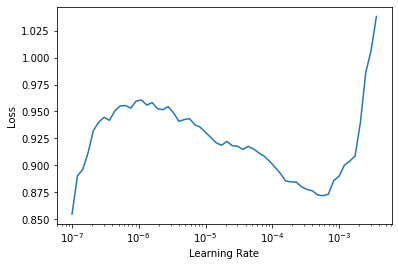

In [37]:
learn.lr_find()

In [38]:
# learn.create_opt()
# learn.opt.freeze_to(-1) # freeze except last param groups
# learn.opt.param_groups[-1]
# learn.opt.freeze_to(-2) # freeze except last two param groups
# learn.opt.param_groups[-2]